In [348]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load data

In [349]:
# df = pd.read_csv('data/Activities_2023_VietAnh.csv')
# date_format = '%m/%d/%y'
# time_format = '%I:%M:%S %p'

df = pd.read_csv('data/phone_usage.csv')
date_format = '%d/%m/%Y'
time_format = '%H:%M:%S'


df = df.dropna() #Recent actions that not end yet

df['Date'] = pd.to_datetime(df['Date'], format= date_format)
df['Time'] = pd.to_datetime(df['Time'], format= time_format)
df['Time'] = df['Time'].dt.time
def time_to_seconds(time_str):
    hours, minutes, seconds = map(int, time_str.split(':'))
    return hours * 3600 + minutes * 60 + seconds

df['Duration'] = df['Duration'].apply(time_to_seconds)

print("Data Preview:")
print(df.head())


ValueError: time data "20:06:27" doesn't match format "%I:%M:%S %p", at position 0. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.

# 2. Data Exploration

## 2.1 App Usage (total time) in the whole month

In [ ]:
app_usage = df.groupby('App name')['Duration'].sum().reset_index()
app_usage = app_usage.sort_values(by='Duration', ascending=False)
top_30_apps = app_usage.head(30)
top_30_apps['Duration'] = top_30_apps['Duration'] / 3600


plt.figure(figsize=(12, 8))
sns.barplot(x='Duration', y='App name', data=top_30_apps, hue='App name', palette='viridis', legend=False)
plt.xlabel('Total Duration (hours)')
plt.ylabel('App name')
plt.title('Top 30 App Usage in Terms of Time for the Month')
plt.show()

TypeError: unsupported operand type(s) for /: 'str' and 'int'

/tmp/ipykernel_42396/1220831198.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_30_apps_remove_first['Duration'] = top_30_apps_remove_first['Duration'] / 3600


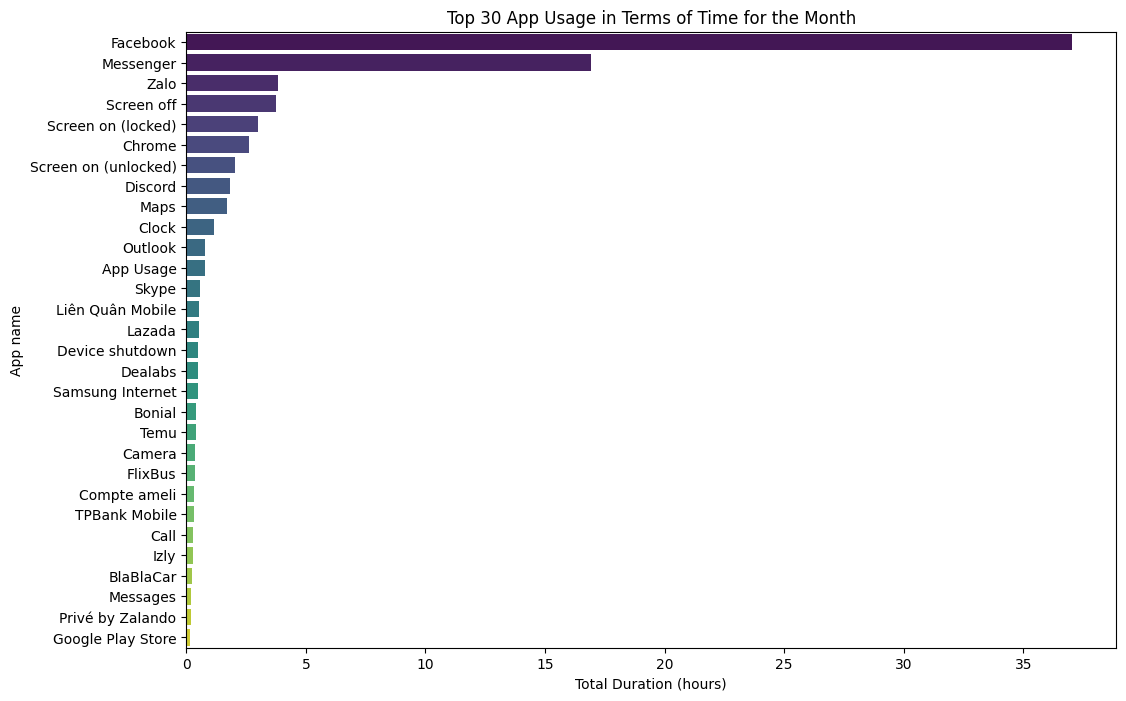

In [ ]:
top_30_apps_remove_first = app_usage.iloc[1:31]
top_30_apps_remove_first['Duration'] = top_30_apps_remove_first['Duration'] / 3600


plt.figure(figsize=(12, 8))
sns.barplot(x='Duration', y='App name', data=top_30_apps_remove_first, hue='App name', palette='viridis', legend=False)
plt.xlabel('Total Duration (hours)')
plt.ylabel('App name')
plt.title('Top 30 App Usage in Terms of Time for the Month')
plt.show()

## 2.2 App Usage (Number of time opened) for the month

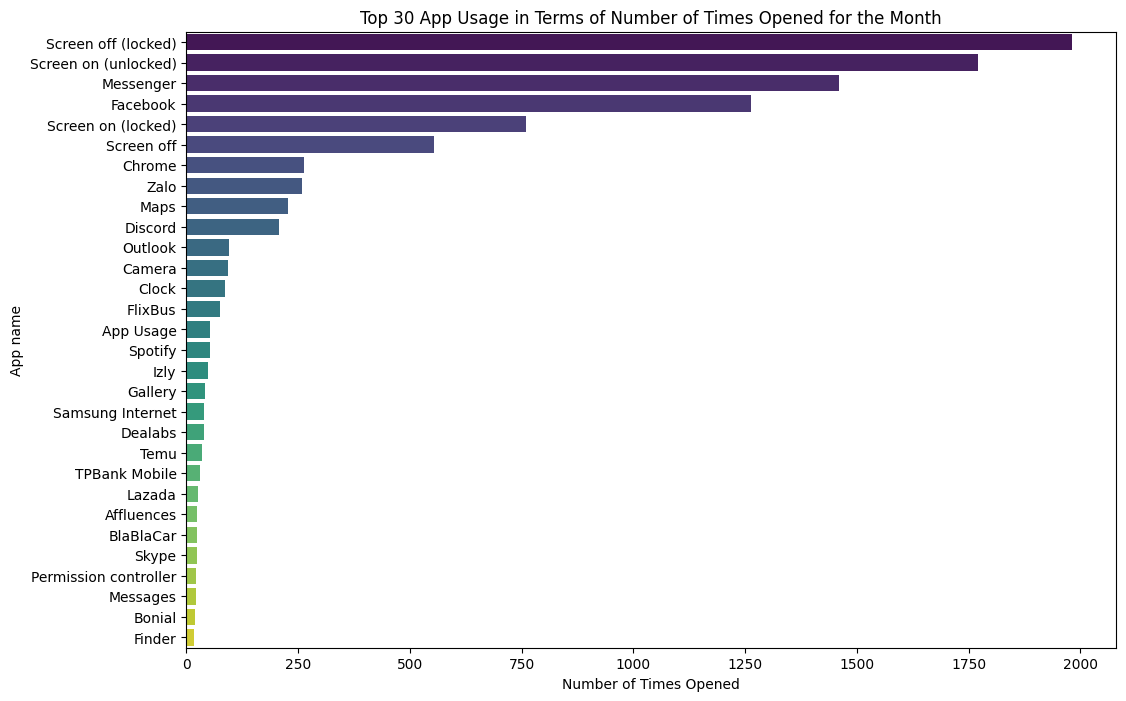

In [ ]:
app_usage = df.groupby('App name')['Date'].count().reset_index()
app_usage = app_usage.sort_values(by='Date', ascending=False)
top_30_apps = app_usage.head(30)

# Rename the 'Date' column to 'Count' for clarity
top_30_apps = top_30_apps.rename(columns={'Date': 'Count'})

# Plotting
plt.figure(figsize=(12, 8))
sns.barplot(x='Count', y='App name', data=top_30_apps, hue='App name', palette='viridis', legend=False)
plt.xlabel('Number of Times Opened')
plt.ylabel('App name')
plt.title('Top 30 App Usage in Terms of Number of Times Opened for the Month')
plt.show()

## 2.3 Heat map of application using 

/tmp/ipykernel_42396/1232647028.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top_20['Time'] = pd.to_datetime(df_top_20['Time'], format='%H:%M:%S').dt.time
/tmp/ipykernel_42396/1232647028.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_top_20['Time_15min'] = pd.to_datetime(df_top_20['Time'].astype(str)).dt.round('15min').dt.time
/tmp/ipykernel_42396/1232647028.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

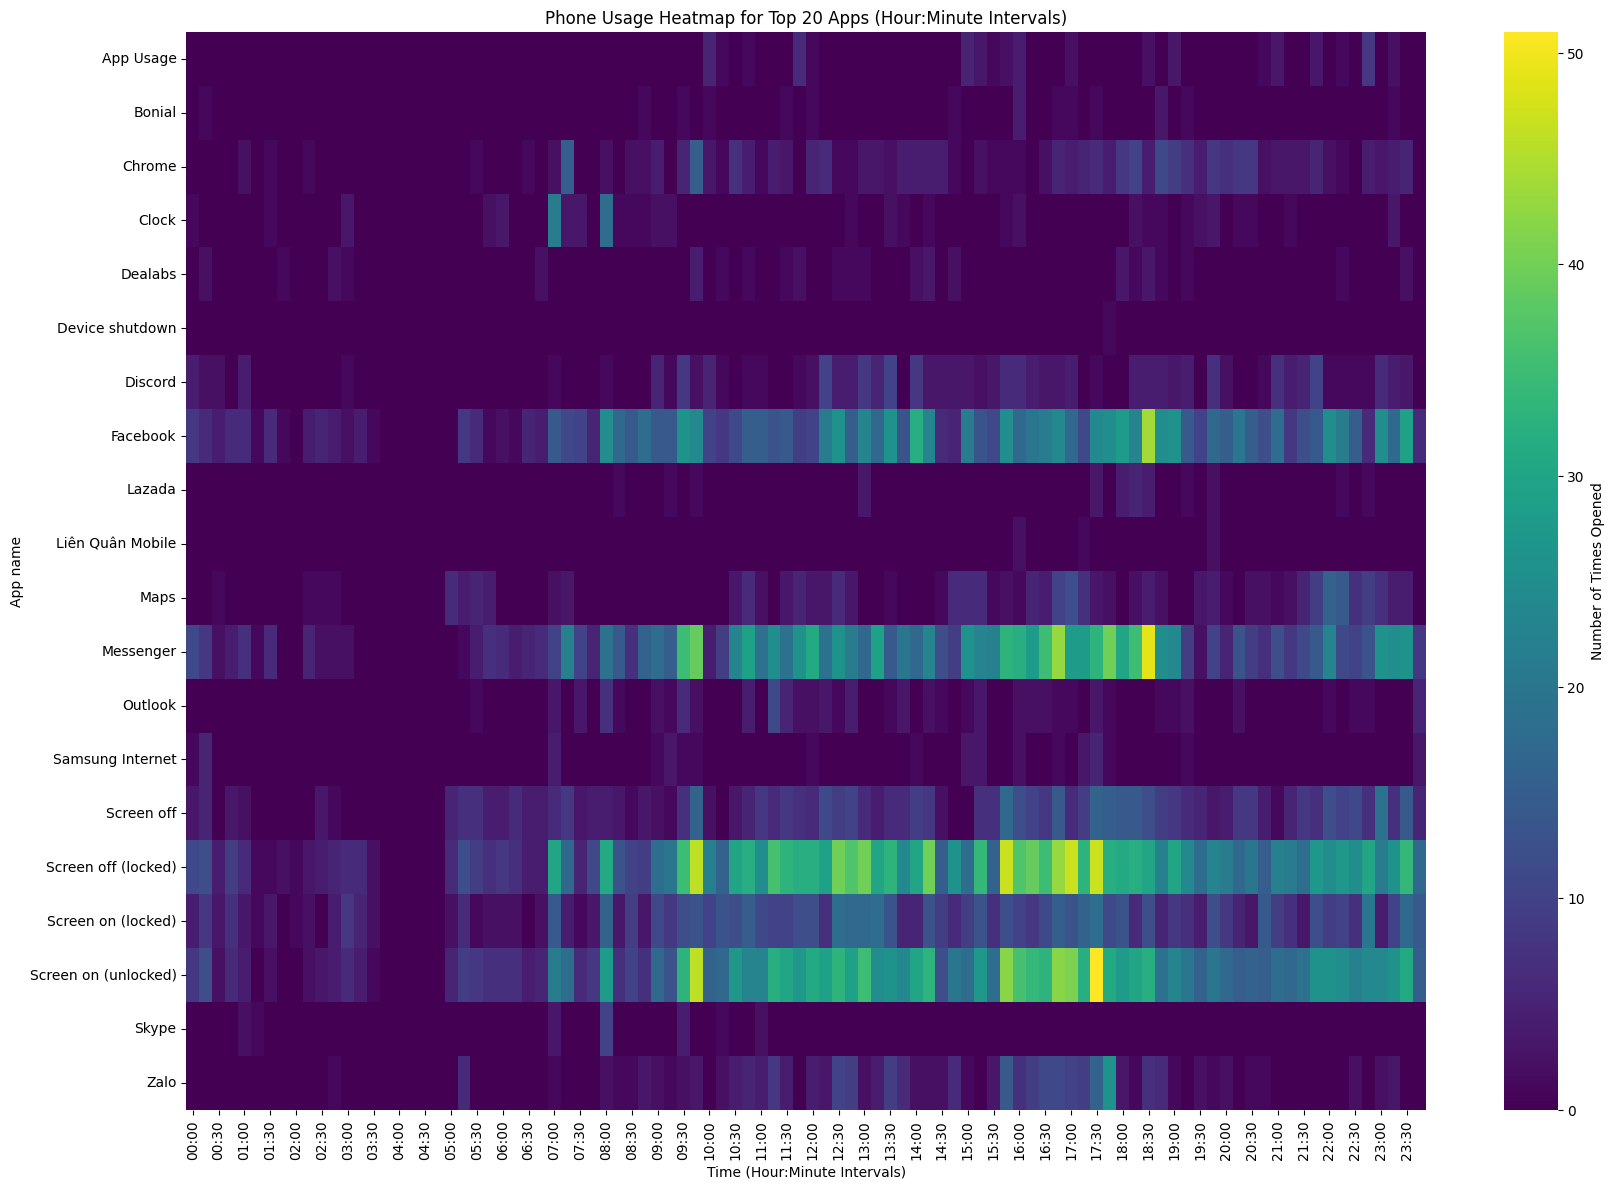

In [ ]:
top_20_apps = df.groupby('App name')['Duration'].sum().nlargest(20).index
df_top_20 = df[df['App name'].isin(top_20_apps)]


df_top_20['Time'] = pd.to_datetime(df_top_20['Time'], format='%H:%M:%S').dt.time
df_top_20['Time_15min'] = pd.to_datetime(df_top_20['Time'].astype(str)).dt.round('15min').dt.time

# Now you can convert 'Time_15min' to the desired string format
df_top_20['Time_15min'] = df_top_20['Time_15min'].astype(str).str[-8:-3]


all_hours = pd.date_range(start="00:00", end="23:59", freq="15min").strftime('%H:%M')
df_top_20_pivot = df_top_20.pivot_table(index='App name', columns='Time_15min', aggfunc='size', fill_value=0)
df_top_20_pivot = df_top_20_pivot.reindex(columns=all_hours, fill_value=0)

plt.figure(figsize=(20, 14))
sns.heatmap(df_top_20_pivot, cmap='viridis', cbar_kws={'label': 'Number of Times Opened'}, annot=False, fmt='g')
plt.xlabel('Time (Hour:Minute Intervals)')
plt.ylabel('App name')
plt.title('Phone Usage Heatmap for Top 20 Apps (Hour:Minute Intervals)')
plt.show()

# 3. Generate the data for visualization

In [ ]:
#Conver to minutes
df['Duration'] = df['Duration'] / 60

# 15 most used apps (duration) (I create others so that we could put other applications in)
top_apps = df['App name'].value_counts().nlargest(14).index.tolist()
df['grp'] = df['App name'].apply(lambda x: x if x in top_apps else 'Others')

date_to_pid = {date: pid for pid, date in enumerate(df['Date'].unique(), start=1)}
df['pid'] = df['Date'].map(date_to_pid)
result_df = df[['pid', 'Date', 'grp', 'Duration']].copy()
result_df = result_df[['pid', 'Date', 'grp', 'Duration']]

#Make the duration to int, eliminate too short periods
result_df['Duration'] = result_df['Duration'].astype('int')
result_df = result_df[result_df['Duration']!=0]

#Change Duration to duration
result_df.rename(columns={"Duration": "duration"}, inplace=True)

result_df.reset_index()
result_df.head(5)

,pid,Date,grp,duration
0,1,2023-12-26,Others,1
3,1,2023-12-26,Screen off (locked),1
10,1,2023-12-26,Screen off (locked),35
11,1,2023-12-26,Facebook,3
14,1,2023-12-26,Screen off (locked),5


In [ ]:
result_df.to_csv('data/VietAnh_processed_data.csv') 